In [40]:
import glob
import os
from collections import Counter
from itertools import combinations, product

import numpy as np
np.random.seed(18012023)

import pandas as pd
pd.set_option('display.max_colwidth', 0)

from sklearn.metrics import pairwise_distances
import lxml.etree
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, precision_score, recall_score, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from IPython.display import display

## Loading and preprocessing

In [2]:
meta_df = pd.read_excel('../data/metadata_corrected.xlsx')
meta_df = meta_df[meta_df['exclude'] != 'x']
meta_df.sample(10)

,id,title,author,date,provenance,date_range,genre,subgenre,exclude
266,van_ses_vaerwen,Van ses vaerwen ende twaelf outheyden,NaN,1410.0,cdrom-mnl,1400-1420,Epiek,Didactiek,NaN
63,florigout_fragm_l,Florigout,NaN,1387.5,cdrom-mnl,1375-1400,Epiek,Ridder,NaN
111,loyhier_en_malaert_fragm_a,Loyhier en Malaert,NaN,1375.0,cdrom-mnl,1350-1400,Epiek,Karel,NaN
86,historie_van_gaver_capeel,Historie van Gaver Capeel,NaN,1510.0,cdrom-mnl,1500-1520,Epiek,Ridder,NaN
168,renout_van_montalbaen_fragm_be,Renout van Montalbaen,NaN,1350.0,cdrom-mnl,1340-1360,Epiek,Karel,NaN
211,spiegel_der_sonden,Spiegel der sonden,NaN,1450.0,cdrom-mnl,1440-1460,Epiek,Didactiek,NaN
210,spiegel_der_jongers,Spiegel der jongers,Lambertus Goetman,1515.0,cdrom-mnl,1510-1520,Epiek,Didactiek,NaN
123,madelgijs_fragm_p,Madelgijs,NaN,1387.5,cdrom-mnl,1375-1400,Epiek,Karel,NaN
166,reinaerts_historie,Reinaerts historie,NaN,1470.0,cdrom-mnl,1460-1480,Epiek,Dier,NaN
239,suverlijc_boecxken,Suverlijc boecxken,NaN,1508.0,cdrom-mnl,1508-1508,Lyriek,NaN,NaN


In [3]:
def get_verse_groups(verses, size=2, intertexts=False):
    for i in range(len(verses) - (size - 1)):
        if not intertexts:
            yield ' / '.join(verses[i : i + size])
        else:
            its = Counter(verses[i : i + size])
            if None in its:
                yield None
            elif len(its) > 1:
                yield 'overlap'
            else:
                yield list(its.keys())[0]

In [4]:
def parse_xml(fn, rm_interpol=False):
    try:
        tree = lxml.etree.parse(fn)
    except OSError:
        print(f'- Could not load {fn}')
        return None
        
    if rm_interpol:
        for interpolation in tree.xpath("//interpolation"):
            interpolation.getparent().remove(interpolation)
        
    for line_node in tree.iterfind('//l'):
        try:
            intertext_id = line_node.attrib['intertext']
        except KeyError:
            intertext_id = None
        
        tokens_ = line_node.attrib['tokens'].split()
        lemmas_ = []
        
        lemma_tags = [l.text for l in line_node.iterfind('.//lemma')]
        pos_tags = [p.text for p in line_node.iterfind('.//pos')]
        
        for lemma, pos in zip(lemma_tags, pos_tags):
            for l, p in zip(lemma.split('+'), pos.split('+')):
                    if p == 'n(prop)':
                        lemmas_.append('n(prop)')
                    else:
                        lemmas_.append(l)
    
        yield tokens_, lemmas_, intertext_id

In [5]:
GROUP_SIZE = 2 #15

titles, tokens, lemmas, intertexts = [], [], [], []

for title, group in tqdm(meta_df.groupby('title')):
    work_tokens, work_lemmas, work_intertexts = [], [], []
    
    for id_ in sorted(group['id']):
        for tok, lem, intertext_id in parse_xml(f'../data/xml/{id_}.xml'):
            work_tokens.append(tok)
            work_lemmas.append(lem)
            work_intertexts.append(intertext_id)
    
    verse_tokens = [' '.join(v) for v in work_tokens]
    verse_lemmas = [' '.join(v) for v in work_lemmas]

    verse_group_tokens = list(get_verse_groups(verse_tokens, size=GROUP_SIZE))
    verse_group_lemmas = list(get_verse_groups(verse_lemmas, size=GROUP_SIZE))
    verse_group_intertexts = list(get_verse_groups(work_intertexts, size=GROUP_SIZE, intertexts=True))

    tokens.extend(verse_group_tokens)
    lemmas.extend(verse_group_lemmas)
    intertexts.extend(verse_group_intertexts)
    titles.extend([title] * len(verse_group_lemmas))

100%|██████████| 205/205 [00:33<00:00,  6.17it/s]


In [6]:
df = pd.DataFrame(zip(titles, tokens, lemmas, intertexts), columns=('title', 'tokens', 'lemmas', 'intertext'))
df = df[df['intertext'] != 'overlap']
df.head()
#df[(df['title'] == 'Karel ende Elegast') & (~df['intertext'].isna())]

,title,tokens,lemmas,intertext
0,AB recht ende averecht,Aensiet dese vrouwen hoe si gaen / Besiet hoe haer tuten staen,aanzien deze vrouw hoe zij gaan / bezien hoe zij de staan,None
1,AB recht ende averecht,Besiet hoe haer tuten staen / Claer dat si hen blanketten,bezien hoe zij de staan / klaar dat zij zij n(prop),None
2,AB recht ende averecht,Claer dat si hen blanketten / Die cleeder soe lanc dat si hen letten,klaar dat zij zij n(prop) / de kleed zo lang dat zij zij letten,None
3,AB recht ende averecht,Die cleeder soe lanc dat si hen letten / Ende sleypen hen nae al op die eerde,de kleed zo lang dat zij zij letten / en slapen zij na al op de aarde,None
4,AB recht ende averecht,Ende sleypen hen nae al op die eerde / Fi diere vuylder hoverde,en slapen zij na al op de aarde / fi duur vouwer hovaardij,None


In [7]:
vec = TfidfVectorizer(max_features=10000, min_df=2, token_pattern=r"(?u)\b\w+\b")
X = vec.fit_transform(df['lemmas'])
X.shape

(924694, 10000)

In [8]:
def add_rhyme_column(df):
    rhyme_words = []
    for lemmas in df['lemmas']:
        rhymes = []
        for verse in lemmas.split(' / '):
            rhymes.append(verse.strip().split()[-1])
        rhyme_words.append(' '.join(rhymes))
    df['rhyme'] = rhyme_words
    return df

In [9]:
df = add_rhyme_column(df)
df.head()
#df[(df['title'] == 'Karel ende Elegast') & (~df['intertext'].isna())]

,title,tokens,lemmas,intertext,rhyme
0,AB recht ende averecht,Aensiet dese vrouwen hoe si gaen / Besiet hoe haer tuten staen,aanzien deze vrouw hoe zij gaan / bezien hoe zij de staan,None,gaan staan
1,AB recht ende averecht,Besiet hoe haer tuten staen / Claer dat si hen blanketten,bezien hoe zij de staan / klaar dat zij zij n(prop),None,staan n(prop)
2,AB recht ende averecht,Claer dat si hen blanketten / Die cleeder soe lanc dat si hen letten,klaar dat zij zij n(prop) / de kleed zo lang dat zij zij letten,None,n(prop) letten
3,AB recht ende averecht,Die cleeder soe lanc dat si hen letten / Ende sleypen hen nae al op die eerde,de kleed zo lang dat zij zij letten / en slapen zij na al op de aarde,None,letten aarde
4,AB recht ende averecht,Ende sleypen hen nae al op die eerde / Fi diere vuylder hoverde,en slapen zij na al op de aarde / fi duur vouwer hovaardij,None,aarde hovaardij


## Nearest neighbors

In [10]:
def nearest_verses(title1, title2, base_df, vectorizer, prop_filt=2, rhyme_weight=.25):
    A = base_df[base_df['title'] == title1]
    B = base_df[base_df['title'] == title2]
    
    AX = vec.transform(A['lemmas']) + rhyme_weight * vec.transform(A['rhyme'])
    BX = vec.transform(B['lemmas']) + rhyme_weight * vec.transform(B['rhyme'])
    
    nearest = []
    for i, ax in enumerate(AX):
        distances = pairwise_distances(ax, BX, metric='cosine').flatten()
        top_i = distances.argsort()[0]
        nearest.append((A.iloc[i]['tokens'], B.iloc[top_i]['tokens'],
                        A.iloc[i]['lemmas'], B.iloc[top_i]['lemmas'],
                        A.iloc[i]['title'], B.iloc[top_i]['title'],
                        A.iloc[i]['intertext'], B.iloc[top_i]['intertext'],
                        distances[top_i]))

    nearest = pd.DataFrame(nearest,
                           columns=['tokens1', 'tokens2', 'lemmas1', 'lemmas2',
                                    'title1', 'title2', 'intertext1', 'intertext2',
                                    'distance'])

    nearest = nearest[nearest['title1'] != nearest['title2']]
    nearest = nearest[
                      (nearest['lemmas1'].str.count('n\(prop\)') < prop_filt) & \
                      (nearest['lemmas1'].str.count('n\(prop\)') < prop_filt) 
                     ]
    return nearest

In [11]:
#nearest_df = nearest_verses('Moriaen', 'Karel ende Elegast',
nearest_df = nearest_verses('Limborch', 'Roman der Lorreinen',
                            base_df=df, vectorizer=vec, prop_filt=2)
nearest_df = nearest_df.sort_values(by='distance')
nearest_df.to_excel('/Users/mikekestemont/Desktop/limb-lorr.xlsx')
nearest_df.head(50)

,tokens1,tokens2,lemmas1,lemmas2,title1,title2,intertext1,intertext2,distance
3335,Smargens doe die dach ontspranc / Entie liwerke sanc,Smargens als die dach ontspranc / Ende die lewerke sanc,de morgen toen de dag ontspringen / de en leeuwerik zingen,de morgen als de dag ontspringen / en de leeuwerik zingen,Limborch,Roman der Lorreinen,None,None,0.028203
6723,Smergens doe die dach ontspranc / Entie liwerke sanc,Smargens als die dach ontspranc / Ende die lewerke sanc,de morgen toen de dag ontspringen / de en leeuwerik zingen,de morgen als de dag ontspringen / en de leeuwerik zingen,Limborch,Roman der Lorreinen,None,None,0.028203
14997,Smargens doe de dach ontspranc / Entie liwerke sanc,Smargens als die dach ontspranc / Ende die lewerke sanc,de morgen toen de dag ontspringen / de en leeuwerik zingen,de morgen als de dag ontspringen / en de leeuwerik zingen,Limborch,Roman der Lorreinen,None,None,0.028203
9024,Ende seide here die macht van gode / Moet u behouden in u ere,Die seide gi heren die macht van gode / Moet v behouden in v ere,en zeggen heer de macht van n(prop) / moeten gij behouden in gij een,die zeggen gij heer de macht van n(prop) / moeten gij behouden in gij een,Limborch,Roman der Lorreinen,None,None,0.031130
2346,Die den keyser goeden dach / Ontboet tierst dat sine sach,Ende teerst datsi den keyser sach / Ontboet si heme goeden dach,de de keizer goed dag / ontbieden eerst het dat zijn zien,en eerst het dat zij de keizer zien / ontbieden zijn hij goed dag,Limborch,Roman der Lorreinen,None,None,0.035548
17189,Ic ligghe hier al miin leven lanc / Of ic hebs minen wille,Jc en hebbe van hem minen wille / Jc ligge hier al mijn leuen lanc,ik liggen hier al mijn leven lang / of ik hebben mijn wil,ik en hebben van hij mijn wil / ik liggen hier al mijn leven lang,Limborch,Roman der Lorreinen,None,None,0.052644
4429,Nu es die ridder in sorgen groet / Ende in anxste van der doet,Die nu sijn in anxste groet / Ende in sorgen van der doet,nu zijn de ridder in zorg groot / en in angst van de dood,die nu zijn in angst groot / en in zorg van de dood,Limborch,Roman der Lorreinen,None,None,0.054563
14979,Seits hem allen groten danc / Daerna over niet lanc,Gierbert seits hare groten danc / Daerna ouer niet lanc,n(prop) hij al groot dank / daarna over niet lang,n(prop) n(prop) haar groot dank / daarna over niet lang,Limborch,Roman der Lorreinen,None,None,0.067203
14175,Gheseit heeft behagedem wale / Hi seide bi Mamet u tale,Huge seide gi segt wale / Mi behaegt wel uwe tale,zeggen hebben behagen wel / hij zeggen bij n(prop) uw taal,n(prop) zeggen gij zeggen wel / ik behagen wel uw taal,Limborch,Roman der Lorreinen,None,None,0.097845
8559,Reden si hem ten gemoete / Dat ontmoet was onsoete,Ende quam den coninc te gemoete / Dat ontmoet was onsoete,rede zij hij te de gemoet / dat ontmoeten zijn onzoet,en komen de koning te gemoet / dat ontmoeten zijn onzoet,Limborch,Roman der Lorreinen,None,None,0.101471


In [12]:
meta = pd.read_excel('../data/intertexts.xlsx')
meta

,ID,source,src-passage,target,trg-passage,verse-length,biblio,remarks,Unnamed: 8
0,mor-ele-1,Moriaen,Dat magic v nv tellen,Karel ende Elegast,Mach ic v tellen,1,"Heeroma 1973a, Moriaen (I)",NaN,NaN
1,mor-ele-2,Moriaen,hilt hof Om te merre sinen lof.,Karel ende Elegast,houden hof Omme te meerne sinen lof:,2,"Heeroma 1973a, Moriaen (I)",NaN,NaN
2,mor-ele-3,Moriaen,Hastelike ende nine spard.,Karel ende Elegast,Haestelic ende niet en spaert:,1,"Heeroma 1973a, Moriaen (I)",NaN,NaN
3,mor-ele-4,Moriaen,Nv nes niweren in ertrike.,Karel ende Elegast,En es man in aertrijcke:,1,"Heeroma 1973a, Moriaen (I)",NaN,NaN
4,mor-ele-5,Moriaen,sine macht (es) so groet Ic waen men nigeren sine genoet Ne soude vinden.,Karel ende Elegast,Mijns selfs lant es soe groot Men vint nyewers sijns ghenoot:,3,"Heeroma 1973a, Moriaen (I)",NaN,NaN
...,...,...,...,...,...,...,...,...,...
224,mor-ele-40,Lantsloot van der Haghedochte,Ende droegen des ouer een:,Moriaen,Ende drogen des daer ouer een.,1,NaN,Nestedness!,NaN
225,mor-ele-61,Lantsloot van der Haghedochte,Dien hi harde lange voer Ende vernam van niemene boer:,Moriaen,Daer men met scepen ouer voer Ende daer verlosic al dat boer.,2,NaN,NaN,NaN
226,lan-ele-74,Lantsloot van der Haghedochte,Ende sijn ors toe gemake gedaen:,Moriaen,Sijn ors was te gemake gedaen.,1,NaN,NaN,NaN
227,lan-ele-75,Lantsloot van der Haghedochte,Doe die dienst was gedaen:,Moriaen,Doe die dinst was gedaen.,1,NaN,NaN,NaN


## Precision-recall paradigm

In [13]:
def precision_recall(df, meta, vec, rhyme_weight=.25):
    titles = set(list(meta['source']) + list(meta['target']))
    relevances, distances = [], []

    for t1, t2 in product(titles, titles):
        if t1 == t2:
            continue

        m = meta[meta['verse-length'] >= 2]
        m = m[(m['source'] == t1) | (m['source'] == t2)]
        m = m[(m['target'] == t1) | (m['target'] == t2)]

        if not len(m):
            continue

        A = df[(~df['intertext'].isna()) & (df['title'] == t1)]
        B = df[df['title'] == t2]

        AX = vec.transform(A['lemmas']) + rhyme_weight * vec.transform(A['rhyme'])
        BX = vec.transform(B['lemmas']) + rhyme_weight * vec.transform(B['rhyme'])

        all_distances = pairwise_distances(AX, BX, metric='cosine')

        for a_idx, (_, a) in enumerate(A.iterrows()):
            distances.extend(all_distances[a_idx])
            relevances.extend((B['intertext'] == a['intertext']).astype(int))
    
    return relevances, distances

In [14]:
relevances, distances = precision_recall(df, meta, vec, rhyme_weight=0)

Use complement of the cosine distance as a pseudo-probability:

In [15]:
distances = 1 - np.array(distances)

max(f1)=0.3538 @ theta=0.5008


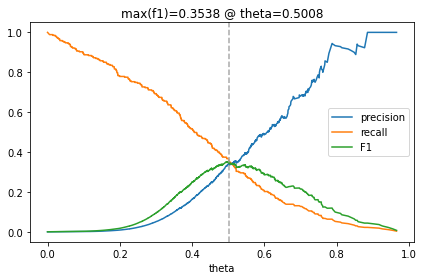

In [16]:
precisions, recalls, thresholds = precision_recall_curve(relevances, distances)
f1s = (2 * precisions * recalls) / (precisions + recalls)

max_f1_idx = np.array(f1s).argmax()
max_f1 = f1s[max_f1_idx]
max_f1_th = thresholds[max_f1_idx]
print(f'max(f1)={round(max_f1, 4)} @ theta={round(max_f1_th, 4)}')

plt.plot(thresholds, precisions[:-1], label='precision')
plt.plot(thresholds, recalls[:-1], label='recall')
plt.plot(thresholds, f1s[:-1], label='F1')
plt.axvline(max_f1_th, ls='--', c='darkgrey')
plt.gca().set_xlabel('theta')
plt.gca().legend()
plt.title(f'max(f1)={round(max_f1, 4)} @ theta={round(max_f1_th, 4)}')
plt.tight_layout()

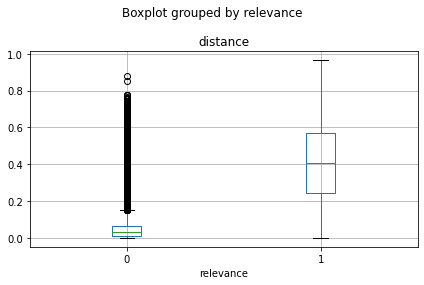

In [17]:
res_df = pd.DataFrame(zip(distances, relevances), columns=('distance', 'relevance'))
res_df.boxplot('distance', 'relevance')
plt.tight_layout();

#### Calibrate parameters

Like rhyme weight:

In [18]:
scores = []

# also negative weight for demonstration purposes:
rhyme_weights = tuple(np.linspace(-.3, 2.0, 50))

from sklearn.metrics import roc_auc_score

for rhyme_weight in tqdm(rhyme_weights):
    relevances, distances = precision_recall(df, meta, vec, rhyme_weight=rhyme_weight)
    distances = 1 - np.array(distances)
    auc = roc_auc_score(relevances, distances)
    av_prec = average_precision_score(relevances, distances)
    scores.append((rhyme_weight, auc, av_prec))

100%|██████████| 50/50 [03:55<00:00,  4.72s/it]


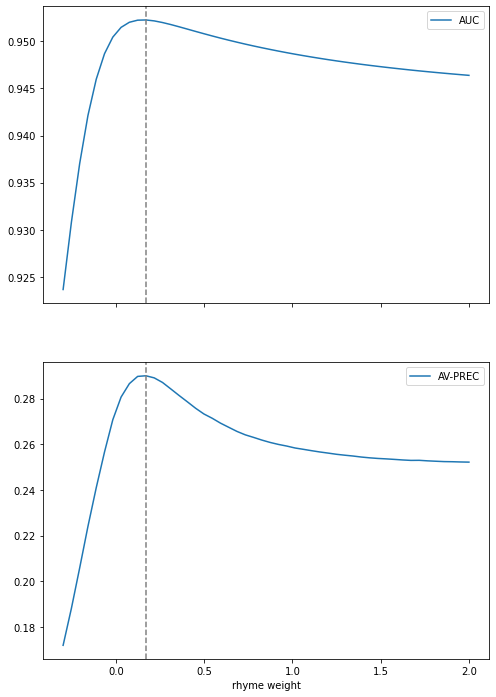

In [19]:
scores = pd.DataFrame(scores, columns=('rhyme weight', 'AUC', 'AV-PREC'))
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 12))
scores.plot('rhyme weight', 'AUC', ax=ax1)
ax1.axvline(scores.iloc[scores['AUC'].idxmax()]['rhyme weight'], ls='--', c='grey')
scores.plot('rhyme weight', 'AV-PREC', ax=ax2)
ax2.axvline(scores.iloc[scores['AV-PREC'].idxmax()]['rhyme weight'], ls='--', c='grey');

In [20]:
optim_rw = scores.iloc[scores['AUC'].idxmax()]['rhyme weight']
optim_rw

0.1693877551020408

Vocabulary size?

In [21]:
vec = TfidfVectorizer(token_pattern=r"(?u)\b\w+\b", min_df=2, max_features=None)
vec.fit(df['lemmas'])
print(len(vec.get_feature_names()))

40568


Vocabulary size for TF and TF-IDF:

In [22]:
scores = []

vocab_sizes = list(range(500, 20000, 500))
parametrizations = {
                    'TF-IDF': {'min_df':2},
                    'TF': {'use_idf':False, 'min_df':2},
                    }

for vocab_size in tqdm(vocab_sizes):
    for param_name, param in parametrizations.items():
        param['max_features'] = vocab_size
        vec = TfidfVectorizer(token_pattern=r"(?u)\b\w+\b", **param)
        vec.fit(df['lemmas'])
        relevances, distances = precision_recall(df, meta, vec, rhyme_weight=optim_rw)
        distances = 1 - np.array(distances)
        auc = roc_auc_score(relevances, distances)
        av_prec = average_precision_score(relevances, distances)
        scores.append((param_name, vocab_size, auc, av_prec))
scores = pd.DataFrame(scores, columns=('param', 'vocab_size', 'AUC', 'AV-PREC'))

100%|██████████| 39/39 [16:39<00:00, 25.63s/it]


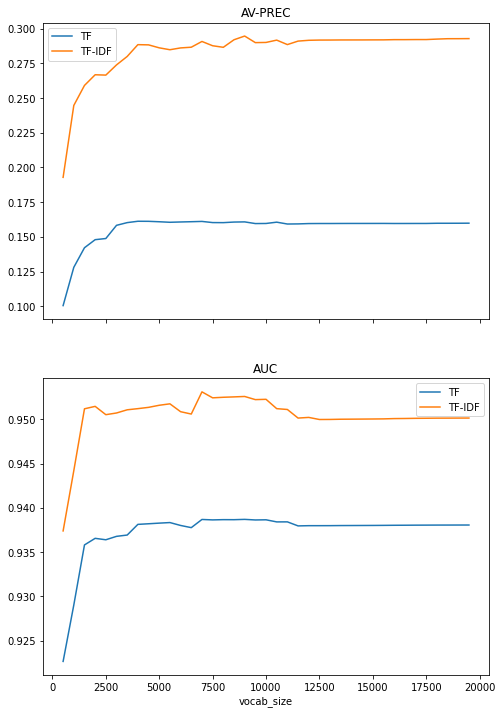

In [23]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 12))

for p, gr in scores.groupby('param'):
    gr.plot('vocab_size', 'AV-PREC', label=p, ax=ax1)
ax1.set_title('AV-PREC')
    
for p, gr in scores.groupby('param'):
    gr.plot('vocab_size', 'AUC', label=p, ax=ax2)
ax2.set_title('AUC');

In [24]:
scores['comb'] = scores['AUC'] * scores['AV-PREC']
optim_vs = scores.iloc[scores['AUC'].idxmax()]
display(optim_vs)
optim_vs = optim_vs['vocab_size']
#optim_vs

param         TF-IDF  
vocab_size    7000    
AUC           0.953101
AV-PREC       0.290712
comb          0.277078
Name: 26, dtype: object

## Final threshold

max(f1)=0.3587 @ theta=0.5624


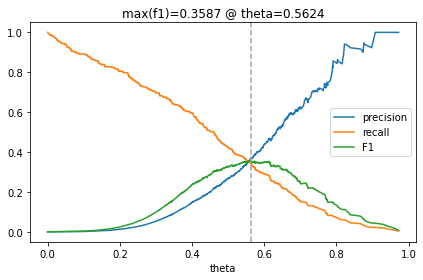

In [25]:
vec = TfidfVectorizer(max_features=40000, min_df=2,
                      token_pattern=r"(?u)\b\w+\b")
vec.fit(df['lemmas'])
relevances, distances = precision_recall(df, meta, vec, rhyme_weight=optim_rw)
distances = 1 - np.array(distances)
precisions, recalls, thresholds = precision_recall_curve(relevances, distances)
f1s = (2 * precisions * recalls) / (precisions + recalls)

max_f1_idx = np.array(f1s).argmax()
max_f1 = f1s[max_f1_idx]
max_f1_th = thresholds[max_f1_idx]
print(f'max(f1)={round(max_f1, 4)} @ theta={round(max_f1_th, 4)}')

plt.plot(thresholds, precisions[:-1], label='precision')
plt.plot(thresholds, recalls[:-1], label='recall')
plt.plot(thresholds, f1s[:-1], label='F1')
plt.axvline(max_f1_th, ls='--', c='darkgrey')
plt.gca().set_xlabel('theta')
plt.gca().legend()
plt.title(f'max(f1)={round(max_f1, 4)} @ theta={round(max_f1_th, 4)}')
plt.tight_layout()

## Case studies

#### Well-known cases of intertextual borrowing

In [26]:
def distance_nn(title1, title2, rhyme_weight=.25, batch_size=5000):
    
    def batch(iterable, n=1):
        l = iterable.shape[0]
        for ndx in range(0, l, n):
            yield iterable[ndx:min(ndx + n, l)]
    
    A = df[df['title'] == title1]
    B = df[df['title'] == title2]

    AX = vec.transform(A['lemmas']) + rhyme_weight * vec.transform(A['rhyme'])
    BX = vec.transform(B['lemmas']) + rhyme_weight * vec.transform(B['rhyme'])

    all_distances = []

    for ax in batch(AX, batch_size):
         all_distances.extend(pairwise_distances(ax, BX, metric='cosine').min(axis=1))
    
    return pd.Series(all_distances)

def plot_min_distance_nn(t1, t2, min_dists, threshold, rolling_size=1000):
    mu = min_dists.rolling(rolling_size).mean()
    fig, ax = plt.subplots()
    mu.plot(ax=ax)
    ax.axhline(threshold, ls='--', c='grey')
    ax.set_ylim(0, 1)
    ax.set_xlabel(t1)
    ax.set_ylabel('Distance to NN in ' + t2)
    return ax

In [27]:
rolling_size, threshold = 1000, 1 - max_f1_th
print(threshold)

0.43762670553485417


Heelu in de Vijfde Partie:

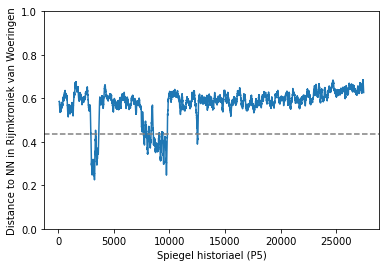

In [28]:
t1, t2 = 'Spiegel historiael (P5)', 'Rijmkroniek van Woeringen'
min_dists = distance_nn(t1, t2, rhyme_weight=optim_rw)
ax = plot_min_distance_nn(t1, t2, min_dists, threshold=threshold, rolling_size=100);

Maerlant in de Brabantse yeesten:

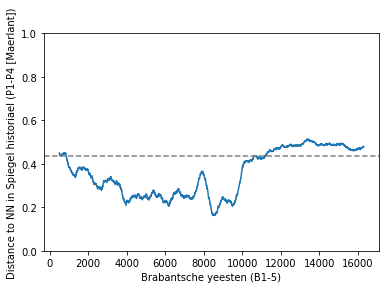

In [29]:
t1, t2 = 'Brabantsche yeesten (B1-5)', 'Spiegel historiael (P1-P4 [Maerlant])'
min_dists = distance_nn(t1, t2, rhyme_weight=optim_rw)
ax = plot_min_distance_nn(t1, t2, min_dists, threshold=threshold, rolling_size=500);

Walewein-passage in Moriaen:

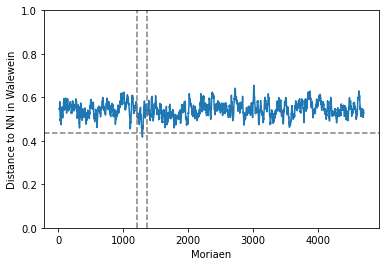

In [30]:
t1, t2 = 'Moriaen', 'Walewein'
min_dists = distance_nn(t1, t2, rhyme_weight=optim_rw)
ax = plot_min_distance_nn(t1, t2, min_dists, threshold=threshold, rolling_size=20)
ax.axvline(1215, c='grey', ls='--')
ax.axvline(1365, c='grey', ls='--');

#### Large-scale detection

In [31]:
#chiv_titles = meta_df[meta_df['subgenre'].isin(('Arthur', 'Ridder', 'Karel', 'Kruisvaart', 'Dier'))]['title'].unique()
chiv_titles = meta_df[meta_df['genre'] == 'Epiek']['title'].unique()
chiv_titles

array(['Alexanders geesten', 'Alexiuslegende', 'Anatomie van de mens',
       'Arturs doet', 'Aubri de Borgengoen', 'Barlaam en Josaphat',
       'Beatrijs', 'Bediedenisse van der missen',
       'Beerte metten breden voeten', 'Beginsel der oorlogen van Luyck',
       'Boec Exemplaer', 'Boec van den houte', 'Boec vander wraken',
       'Boeve van Hamtone', 'Borchgrave van Couchi',
       'Borchgravinne van Vergi (1)', 'Borchgravinne van Vergi (2)',
       'Boudewijn van Seborch', 'Brabantsche yeesten (B1-5)',
       'Brabantsche yeesten (B6)', 'Brabantsche yeesten (B7)',
       'Nevelingenlied', "Chanson d'Aspremont", 'Collectief lunarium I',
       'Collectief lunarium III', 'Commentaar op het Hooglied',
       'Collectief lunarium II', 'Cyromanchie van den pape van den Hamme',
       'Der leken spieghel', 'Der mannen ende vrouwen heimelijcheit',
       'Der minnen loep', 'Der naturen bloeme',
       'Der vrouwen heimelijcheit', 'Der ystorien bloeme',
       'Dietsche doctrinale', 'Di

In [32]:
#results = []
#for t1, t2 in tqdm(product(['Arturs doet'], chiv_titles)):
#for t1, t2 in tqdm(product(['Karel ende Elegast'], chiv_titles)):
#for t1, t2 in tqdm(list(product(chiv_titles, chiv_titles))):
#    if t1 == t2:
#        continue
#    results.append((t1, t2, distance_nn(t1, t2, batch_size=10000)))

In [33]:
#results = pd.DataFrame(results, columns=('t1', 't2', 'nn'))
#results

In [34]:
#rolling_size = 100
#for _, r in results.iterrows():
#    if np.any(r['nn'].rolling(rolling_size).mean() < threshold):
#        plot_min_distance_nn(r['t1'], r['t2'], r['nn'],
#threshold=threshold, rolling_size=rolling_size);

### Single-text

In [39]:
#for t in chiv_titles:
#    d = results[results['t1'] == t]
#    D = np.array([_ for _ in d['nn'].values])
#    D = pd.DataFrame(D)
#    D.mean().rolling(50).mean().plot(title=t)
#    plt.ylim(0, 1)
#    plt.show()

## Scene fishing

Parse prieel:

In [ ]:
#GROUP_SIZE = 15

#work_tokens, work_lemmas = [], []
#for tok, lem, intertext_id in parse_xml('prieel.xml'):
#    work_tokens.append(tok)
#    work_lemmas.append(lem)

#verse_tokens = [' '.join(v) for v in work_tokens]
#verse_lemmas = [' '.join(v) for v in work_lemmas]

#verse_group_tokens = list(get_verse_groups(verse_tokens, size=GROUP_SIZE))
#verse_group_lemmas = list(get_verse_groups(verse_lemmas, size=GROUP_SIZE))

In [ ]:
#prieel = pd.DataFrame(zip(['prieel'], verse_group_tokens, verse_group_lemmas),
#                      columns=('title', 'tokens', 'lemmas'))
#prieel = add_rhyme_column(prieel)
#prieel.head()

In [ ]:
#rhyme_weight = optim_rw
#AX = vec.transform(prieel['lemmas']) + rhyme_weight * vec.transform(prieel['rhyme'])

#for title2 in df['title'].unique():
#for title2 in ['Limborch']:
#    B = df[df['title'] == title2]
#    BX = vec.transform(B['lemmas']) + rhyme_weight * vec.transform(B['rhyme'])
#    D = pd.Series(pairwise_distances(BX, AX, metric='cosine').min(axis=1))
#    if D.min() < .77:
#        plot_min_distance_nn('Prieel', title2, D, threshold=.5,  rolling_size=15)
#        display(B.iloc[D.argmin()])

## Unicity?

title        Der naturen bloeme                                              
tokens       ende groet den dach alsi ontsprinct / jndien tiden dat soe sinct
lemmas       en groot de dag als zij ontspringen / in de tijd dat zij zingen 
intertext    None                                                            
rhyme        ontspringen zingen                                              
Name: 159711, dtype: object

title        Limborch                                                  
tokens       Smargens doe die dach ontspranc / Entie liwerke sanc      
lemmas       de morgen toen de dag ontspringen / de en leeuwerik zingen
intertext    None                                                      
rhyme        ontspringen zingen                                        
Name: 392567, dtype: object

title        Moriaen                                                       
tokens       Hadde gelesen ende gesongen / Van dat die dach was ontsprongen
lemmas       hebben lezen en zingen / van dat de dag zijn ontspringen      
intertext    None                                                          
rhyme        zingen ontspringen                                            
Name: 467926, dtype: object

title        Roman der Lorreinen                                      
tokens       Smargens als die dach ontspranc / Ende die lewerke sanc  
lemmas       de morgen als de dag ontspringen / en de leeuwerik zingen
intertext    None                                                     
rhyme        ontspringen zingen                                       
Name: 589991, dtype: object

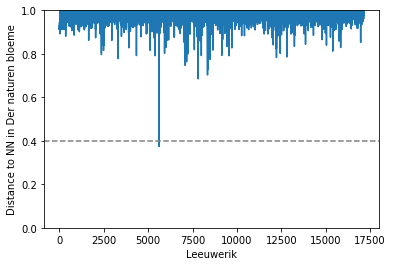

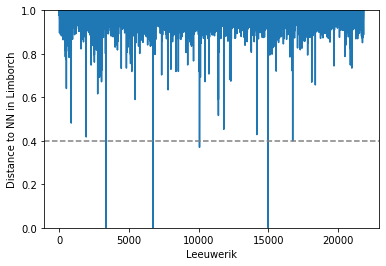

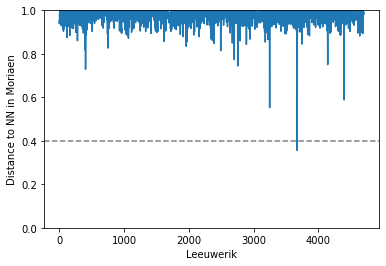

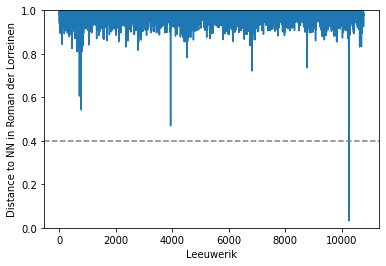

In [36]:
rhyme_weight = .15
threshold = .4
A = df[df['title'] == 'Limborch'].iloc[nearest_df.iloc[0].name]
AX = vec.transform([A['lemmas']]) + rhyme_weight * vec.transform([A['rhyme']])

for title2 in df['title'].unique():
#for title2 in ['Roman der Lorreinen']:
    B = df[df['title'] == title2]
    BX = vec.transform(B['lemmas']) + rhyme_weight * vec.transform(B['rhyme'])
    D = pd.Series(pairwise_distances(BX, AX, metric='cosine').min(axis=1))
    if D.min() < threshold:
        plot_min_distance_nn('Leeuwerik', title2, D, threshold=threshold,  rolling_size=1)
        display(B.iloc[D.argmin()])

## Statistical analysis

In [41]:
results = []

select_titles = chiv_titles

for t1, t2 in tqdm(list(product(select_titles, select_titles))):
    if t1 == t2:
        continue
    
    # genre
    g1 = meta_df[meta_df['title'] == t1]['genre'].iloc[0]
    g2 = meta_df[meta_df['title'] == t2]['genre'].iloc[0]
    
    # subgenre
    sg1 = meta_df[meta_df['title'] == t1]['subgenre'].iloc[0]
    sg2 = meta_df[meta_df['title'] == t2]['subgenre'].iloc[0]
    
    # date
    d1 = meta_df[meta_df['title'] == t1]['date'].iloc[0]
    d2 = meta_df[meta_df['title'] == t2]['date'].iloc[0]
    
    # author
    a1 = meta_df[meta_df['title'] == t1]['author'].iloc[0]
    a2 = meta_df[meta_df['title'] == t2]['author'].iloc[0]

    
    NNs = distance_nn(t1, t2, batch_size=10000)
    hits = np.sum(NNs <= threshold) / ( len(df[df['title'] == t1]) + len(df[df['title'] == t2]))
    results.append((t1, t2, hits, g1, g2, sg1, sg2, d1, d2, a1, a2))
    
results = pd.DataFrame(results, columns=['t1', 't2', 'hits', 'genre1', 'genre2',
                                         'subgenre1', 'subgenre2', 'date1', 'date2',
                                         'author1', 'author2'])
results.to_excel('statistics.xlsx', index=False)
results

100%|██████████| 25921/25921 [25:17:47<00:00,  3.51s/it]       


,t1,t2,hits,genre1,genre2,subgenre1,subgenre2,date1,date2,author1,author2
0,Alexanders geesten,Alexiuslegende,0.000000,Epiek,Epiek,Ridder,Heiligenleven,1400.0,1295.5,Jacob van Maerlant,NaN
1,Alexanders geesten,Anatomie van de mens,0.000903,Epiek,Epiek,Ridder,Didactiek,1400.0,1375.0,Jacob van Maerlant,NaN
2,Alexanders geesten,Arturs doet,0.040564,Epiek,Epiek,Ridder,Arthur,1400.0,1325.0,Jacob van Maerlant,NaN
3,Alexanders geesten,Aubri de Borgengoen,0.008172,Epiek,Epiek,Ridder,Karel,1400.0,1350.0,Jacob van Maerlant,NaN
4,Alexanders geesten,Barlaam en Josaphat,0.001806,Epiek,Epiek,Ridder,Ridder,1400.0,1387.5,Jacob van Maerlant,NaN
...,...,...,...,...,...,...,...,...,...,...,...
25755,Merlijn-continuatie,Walewein,0.035389,Epiek,Epiek,Arthur,Arthur,1425.0,1350.0,Lodewijk van Velthem,Penninc en Pieter Vostaert
25756,Merlijn-continuatie,Walewein ende Keye,0.051769,Epiek,Epiek,Arthur,Arthur,1425.0,1325.0,Lodewijk van Velthem,NaN
25757,Merlijn-continuatie,Willem van Oringen,0.004553,Epiek,Epiek,Arthur,Karel,1425.0,1325.0,Lodewijk van Velthem,Clays van Haerlem
25758,Merlijn-continuatie,Wisselau,0.008085,Epiek,Epiek,Arthur,Karel,1425.0,1295.5,Lodewijk van Velthem,NaN


In [42]:
results = pd.read_excel('statistics.xlsx')
results.sample(10)

,t1,t2,hits,genre1,genre2,subgenre1,subgenre2,date1,date2,author1,author2
23611,Van sente Brandane,Ongeïdentificeerd (4),0.003302,Epiek,Epiek,Heiligenleven,Karel,1402.5,1350.0,NaN,NaN
173,Alexiuslegende,Borchgrave van Couchi,0.000000,Epiek,Epiek,Heiligenleven,Ridder,1295.5,1387.5,NaN,NaN
19859,Speghel der wijsheit,Brabantsche yeesten (B6),0.006708,Epiek,Epiek,Didactiek,Historiografie,1450.0,1432.0,Jan Praet,NaN
7509,Floris ende Blancefloer,Vande Hertogen ende Heeren van Brabant,0.001393,Epiek,Epiek,Ridder,Historiografie,1350.0,1580.0,Diederic van Assenede,NaN
3975,Collectief lunarium III,Valentijn en Nameloos,0.000912,Epiek,Epiek,Didactiek,Ridder,1450.0,1350.0,NaN,NaN
11628,Leven van Sint Trudo (berijming),Roman van Cassamus (kort),0.000457,Epiek,Epiek,Heiligenleven,Ridder,1400.0,1325.0,NaN,NaN
7190,Florigout,Vanden levene ons heren,0.006100,Epiek,Epiek,Ridder,Heiligenleven,1387.5,1438.0,NaN,NaN
21419,Tien plaghen ende die tien ghebode,Van den VII Vroeden van binnen Rome,0.002003,Epiek,Epiek,Didactiek,Didactiek,1400.0,1375.0,NaN,NaN
24367,Vander rijcheit ende vander doot,Flovent,0.000000,Epiek,Epiek,Didactiek,Karel,1410.0,1450.0,Augustijnken,NaN
1086,Beatrijs,Spiegel historiael (P1-P4 [Maerlant]),0.001694,Epiek,Epiek,Didactiek,Historiografie,1374.0,1312.5,NaN,Jacob van Maerlant
